<a href="https://colab.research.google.com/github/FaridRasulov/QRNN/blob/master/QRNN_TF_2x_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import os.path
import sys
import json
import numpy as np
import tensorflow as tf
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
drive.mount('/content/gdrive')
tf.test.gpu_device_name()

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/device:GPU:0'

In [0]:
def get_embeddings(vocab, path, dim = 300):
    vocab_dict = {word: int(_id) for _id, word in vocab.items()}
    embed_id = path.split('.')[-2]
    if embed_id+'_imdb.json' not in os.listdir('.'):
        embeds = {}
        with open(path, encoding="utf8") as f:
            for line in f:
                split = line.split()
                word = split[0].encode('utf-8').lower()
                vec = split[1:]
                if word in vocab_dict.keys():
                    embeds[vocab_dict[word]] = list(map(float,vec))
        with open(embed_id+'_imdb.json', 'w') as f:
            f.write(json.dumps(embeds))
    else:
        with open(embed_id+'_imdb.json') as f:
            embeds = {int(_id): word for _id, word in json.loads(f.read()).items()}
    embed_list = []
    for i in range(3):
        initializer = tf.initializers.GlorotUniform()
        var = tf.Variable(initializer(shape=[dim]))
        embed_list.append(var)
    for _id, word in vocab.items():
        if int(_id) in embeds.keys(): embed_list.append(tf.constant(embeds[_id], dtype=tf.float32))
        else: embed_list.append(embed_list[2])
    return tf.stack(embed_list, axis=0)

class imdbDataset(Dataset):
    def __init__(self, dataset, seq_len=100):
        self.x = dataset[0]
        self.pad_inputs(seq_len)
        self.get_masks(seq_len)
        self.y = dataset[1]

    def pad_inputs(self, seq_len):
        new_xs = []
        for x in self.x:
            if len(x) > seq_len: x = x[:seq_len]
            elif len(x) < seq_len: x += [0] * (seq_len - len(x))
            assert len(x) == seq_len
            new_xs.append(x)
        self.x = new_xs

    def get_masks(self, seq_len):
        self.masks = []
        for x in self.x:
            mask = [1.0 * (x_i != 0) for x_i in x]
            assert len(mask) == seq_len
            self.masks.append(mask)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.masks[i], self.y[i]

def plot_performance(train, val, label):
    plt.plot(train)
    plt.plot(val)
    plt.ylabel(label)
    plt.xlabel('epoch')
    if label=='acc':
      plt.legend(['train', 'val'], loc='lower right')
    elif label=='loss':
      plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()

def get_datasets(batch_size=100, num_words=1000, seq_len=100):
    train, test = imdb.load_data(num_words=num_words)
    vocab = imdb.get_word_index()
    vocab = {int(_id): word.encode('utf-8').lower() for word, _id in vocab.items() if _id <= num_words}
    train = imdbDataset(train, seq_len=seq_len)
    n = int(len(test[0])/2)
    val = imdbDataset((test[0][0:n], test[1][0:n]), seq_len=seq_len)
    test = imdbDataset((test[0][n:], test[1][n:]), seq_len=seq_len)
    # if os.path.isfile('./glove.6B.300d.txt')==False:
    #         !wget http://nlp.stanford.edu/data/glove.6B.zip
    #         !unzip glove*.zip
    return (DataLoader(train, batch_size), DataLoader(val, batch_size), DataLoader(test, batch_size), vocab)

**Step 1: Apply convolutions to compute intermediate vectors and gating vectors**

QRNNs use a regular convolution layer1 in the timestep dimension to compute three vectors for each input: a candidate vector, a forget gate, and an output gate. More specifically, given an input sequence of n-dimensional vectors x_1, x_2, ... x_T , the convolution layer for the candidate vectors with m filters produces a sequence of T m-dimensional output vectors z_1, z_2, ..., z_T . The same goes for the forget gates and output gates. The precise equations are

In [0]:
class DenseModel:
    def __init__(self, BATCH_SIZE, SEQ_LEN, num_layers, hidden_size, conv_size, zoneout=0.1, dropout = 0.3, num_in_channels = 1):
        self.batch_size = BATCH_SIZE
        self.seq_len = SEQ_LEN
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.conv_size = conv_size
        self.dropout = dropout
        self.zoneout = zoneout
        self.weights = []
        self.biases = []
        for i in range(num_layers):
          exec('self.W_'+str(i)+' = tf.Variable(tf.random.normal([conv_size, hidden_size, num_in_channels+'+str(i)+', hidden_size*3]), trainable=True)')
          exec('self.weights.append(self.W_'+str(i)+')')
          exec('self.b_'+str(i)+' = tf.Variable(tf.random.normal([hidden_size*(3)]), trainable=True)')
          exec('self.biases.append(self.b_'+str(i)+')')
        self.inputsDense = tf.keras.layers.Dense(hidden_size)
        self.outputsDense = tf.keras.layers.Dense(2, dtype='float64')

    def __call__(self, inputs, masks, train):        
        inputs = tf.expand_dims(tf.nn.embedding_lookup(embeddings, inputs), -1)
        inputs = self.inputsDense(tf.transpose(inputs, [0, 1, 3, 2]))
        inputs = tf.transpose(inputs, [1, 0, 3, 2])
        for wb in zip(self.weights, self.biases):
            outputs = self.Layer(inputs, wb[0], wb[1], train=train)
            outputs = tf.nn.dropout(outputs, 1 - self.dropout) if train else outputs
            inputs = tf.concat([inputs, outputs], 3)
        inputs = tf.squeeze(outputs[:, :, :, -1])
        inputs = tf.transpose(tf.cast(inputs,dtype='float64'), perm=[1, 0, 2])
        outputs = tf.reduce_mean(inputs * tf.expand_dims(masks, -1), 1)
        logits = self.outputsDense(tf.squeeze(outputs))
        pred = tf.argmax(tf.nn.softmax(logits), -1)   
        return logits, pred

    def Layer(self, data, W, b, train):
        padded_data = tf.pad(data, [[0, 0], [self.conv_size - 1, 0], [0, 0], [0, 0]], "CONSTANT")
        conv = tf.nn.conv2d(padded_data, W, strides=[1, 1, 1, 1],padding='VALID') + b
        gates = tf.split(conv, 3, 3)
        F = gates[2]
        F = 1-tf.nn.dropout(F, 1-self.zoneout)if train else F
        gates[2] = F
        gates[0] = tf.tanh(gates[0])
        for i in range(1, len(gates)):
            gates[i] = tf.sigmoid(gates[i])
        Z, F, O = gates
        Z = tf.unstack(Z, axis=1)
        F = tf.unstack(F, axis=1)
        O = tf.unstack(O, axis=1)
        C = [tf.zeros(tf.shape(Z[0]), tf.float32)] # #
        H = []
        for i in range(len(Z)):
            c = tf.multiply(F[i], C[-1]) + tf.multiply(1-F[i], Z[i])
            h = tf.multiply(O[i], c)
            C.append(c)
            H.append(h)
        H = tf.stack(H, axis=1)
        return tf.transpose(H, perm=[0, 1, 3, 2])

In [0]:
NUM_EPOCHS = 5
BATCH_SIZE = 25
SEQ_LEN = 400
VOCAB_SIZE = 68379
num_layers = 4
hidden_size = 256
conv_size = 2

trainset, valset, testset, vocab = get_datasets(BATCH_SIZE,VOCAB_SIZE,SEQ_LEN)
embeddings = get_embeddings(vocab, './gdrive/My Drive/glove.6B.300d.txt')

In [45]:
model = DenseModel(BATCH_SIZE, SEQ_LEN, num_layers, hidden_size, conv_size)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []
acc_history = []

@tf.function
def Train(model, inputs, masks, labels):
    batch_loss = []
    batch_acc = []
    with tf.GradientTape() as tape:
      logits, pred = model(inputs, masks, train=True)
      loss_value = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
      cost = tf.reduce_sum(loss_value)/BATCH_SIZE
      correct_prediction = tf.equal(pred, labels)
      acc_value = tf.reduce_sum(tf.cast(correct_prediction,tf.float32))/BATCH_SIZE

    batch_loss.append(loss_value)
    batch_acc.append(acc_value)
    grads = tape.gradient(loss_value, model.weights+model.biases)
    optimizer.apply_gradients(zip(grads, model.weights+model.biases))
    return batch_loss, batch_acc

for epoch in range(NUM_EPOCHS):
    for x, masks, y in trainset:
      inputs = np.array([i.numpy() for i in x]).T
      masks = np.array([i.numpy() for i in masks]).T
      labels = np.array([i.numpy() for i in y]).T
      batch_loss, batch_acc= Train(model, inputs, masks, labels)
    loss_history.append(np.mean(batch_loss))
    acc_history.append(np.mean(batch_acc))
    print ('Epoch: {}\tTrain loss: {}\tTrain accuracy: {}'.format(epoch, loss_history[epoch], acc_history[epoch]))

Epoch: 0	Train loss: 0.6933415883133941	Train accuracy: 0.3999999761581421
Epoch: 1	Train loss: 0.6946141617179831	Train accuracy: 0.47999998927116394
Epoch: 2	Train loss: 0.6908518597530481	Train accuracy: 0.5199999809265137
Epoch: 3	Train loss: 0.6817826160651025	Train accuracy: 0.5999999642372131
Epoch: 4	Train loss: 0.6986812231715832	Train accuracy: 0.3999999761581421


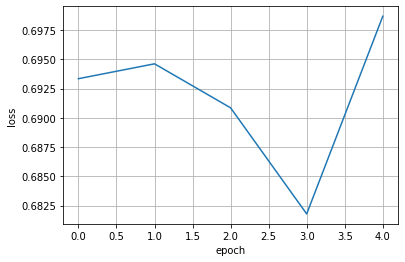

In [47]:
import matplotlib.pyplot as plt
loss = [loss_history[i] for i in range(len(loss_history))]
plt.plot(loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

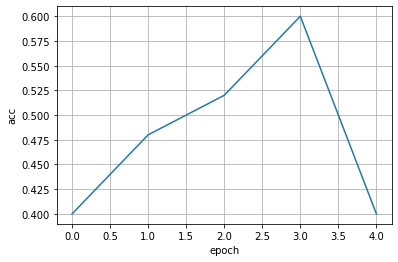

In [48]:
import matplotlib.pyplot as plt
acc = [acc_history[i] for i in range(len(acc_history))]
plt.plot(acc)
plt.ylabel('acc')
plt.xlabel('epoch')
plt.grid()
plt.show()